In [26]:
import matplotlib.pyplot as plt
# import dataprep # this not working
import pandas as pd
import numpy as np
# Import the data
signal_data = pd.read_hdf("/dice/projects/CMS/Hinv/datasets_for_ml_training/ttH/df_ml_inputs.hd5")
background_data = pd.read_hdf("/dice/projects/CMS/Hinv/datasets_for_ml_training/ttBar/df_ml_inputs.hd5")

loss_factor = 1

def prep(signal_data, background_data):

    import pandas as pd
    import numpy as np

    # Remove nan values
    signal_data = signal_data.dropna()
    background_data = background_data.dropna()

    # Remove regions 1-5 as they contain data not suitable for training
    signal_data = signal_data[~signal_data.region.isin([1, 2, 3, 4, 5])]
    background_data = background_data[~background_data.region.isin([1, 2, 3, 4, 5])]

    # Adding in balance weights to deal with the class imbalance

    signal_data['weight_balance'] = loss_factor * len(background_data) / len(signal_data)
    # signal_data['weight_balance'] = 1
    background_data['weight_balance'] = 1

    # Combine data + add feautures
    signal_data['target'] = 1
    background_data['target'] = 0
    data = pd.concat([signal_data, background_data])

    # Creation of additional useful features found from 'investigatingjets.ipynb'
    # cleanedJet_eta_std, cleanedJet_eta_range, cleadJet_phi_std, cleanedJet_phi_range

    data['cleanedJet_eta_std'] = data['cleanedJet_eta'].apply(lambda x: np.std(x))
    data['cleanedJet_eta_range'] = data['cleanedJet_eta'].apply(lambda x: np.max(x) - np.min(x))
    data['cleanedJet_phi_std'] = data['cleanedJet_phi'].apply(lambda x: np.std(x))
    data['cleanedJet_phi_range'] = data['cleanedJet_phi'].apply(lambda x: np.max(x) - np.min(x))

    return data
    
data = prep(signal_data, background_data)

data

,dataset,entry,DiJet_mass,HT,InputMet_InputJet_mindPhi,InputMet_phi,InputMet_pt,MHT_phi,MHT_pt,MinChi,...,sdphi_bjet,sdphi_jet,weight_nominal,xs_weight,weight_balance,target,cleanedJet_eta_std,cleanedJet_eta_range,cleanedJet_phi_std,cleanedJet_phi_range
0,ttH125,13,341.072355,640.688171,1.371094,-2.791016,421.000,-2.723288,391.416199,0.989503,...,1.369123,2.165998,9.393444e-08,8.695861e-08,2.990639,1,0.502485,1.403809,1.620482,4.705078
2,ttH125,103,216.669163,483.973785,0.987305,-2.919922,267.750,-2.735934,229.776871,1.249071,...,2.462873,2.112305,1.068131e-07,8.695861e-08,2.990639,1,0.629593,1.934814,1.129019,3.496094
5,ttH125,133,268.957177,599.465881,0.266113,0.861328,314.500,0.761660,271.450897,0.259827,...,2.115234,2.115234,7.158158e-08,8.695861e-08,2.990639,1,0.572154,1.939697,1.937414,5.722656
8,ttH125,162,103.852234,512.995422,0.944336,2.490234,269.750,2.502656,283.620880,1.190123,...,1.646484,2.939924,6.904837e-08,8.695861e-08,2.990639,1,0.633992,2.016602,1.095436,2.893555
9,ttH125,166,113.079749,1004.342773,0.183838,-1.972656,201.875,-2.058019,211.153290,0.330619,...,0.189453,3.005859,9.084001e-08,8.695861e-08,2.990639,1,1.076340,3.970703,1.842891,5.611328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1251581,TTToSemiLeptonic,18894,1048.986596,1745.931152,0.127808,0.777832,637.500,0.862875,659.301392,0.034632,...,1.113525,0.207031,5.399820e-07,1.058815e-06,1.000000,0,0.992705,2.969238,1.518086,4.373047
1251586,TTToSemiLeptonic,19047,492.002987,807.895142,0.644043,2.154297,405.000,1.952985,330.999756,0.005709,...,2.130707,0.644531,2.749653e-08,1.058815e-06,1.000000,0,0.607883,1.817871,1.849368,5.625000
1251587,TTToSemiLeptonic,19077,143.497757,691.556885,0.637695,3.085938,293.500,2.867620,221.293930,0.659506,...,0.738281,3.113935,6.436018e-07,1.058815e-06,1.000000,0,0.692297,1.680664,1.461173,3.229492
1251591,TTToSemiLeptonic,19207,104.665869,472.002991,1.773438,-1.448242,329.500,-1.333643,331.776306,1.443549,...,1.110596,3.122070,9.757773e-07,1.058815e-06,1.000000,0,1.451778,4.112305,0.959015,2.681396


In [27]:
# List of variables to use for training
features = ['DiJet_mass', 'HT', 'InputMet_InputJet_mindPhi',
       'InputMet_pt', 'MHT_pt', 'MinChi',
       'MinOmegaHat', 'MinOmegaTilde', 'cleanedJet_eta_std', 'cleanedJet_eta_range',
       'cleanedJet_phi_range', 'cleanedJet_phi_std', 'ldphi_bjet',
       'ldphi_jet', 'ncleanedBJet', 'ncleanedJet', 'region', 'sdphi_bjet',
       'sdphi_jet']


weights_copy = data['weight_nominal'].copy() # Use this one for saving the weights when balancing by adding weight_balance

### Model and training

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


# MODEL PARAMETERS

n_layers = 2
n_neurons = 64
lr = 0.01
batch_size = 64
dropout_rate = 0

# Standardize the features
scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])

# Convert data to PyTorch tensors
X = torch.tensor(data[features].values, dtype=torch.float32)
y = torch.tensor(data['target'].values, dtype=torch.float32)  # For BCE loss, use float labels
weights_nominal = torch.tensor(data['weight_nominal'].values, dtype=torch.float32)
weights_balance = torch.tensor(data['weight_balance'].values, dtype=torch.float32)

# Split data into training+validation and test sets (80/20)
X_train_val, X_test, y_train_val, y_test, wn_train_val, wn_test, wb_train_val, wb_test = train_test_split(X, y, weights_nominal, weights_balance, test_size=0.2, random_state=42)

# Further split the training data into train and validation sets (80/20 of 80%)
X_train, X_val, y_train, y_val, wn_train, wn_val, wb_train, wb_val  = train_test_split(X_train_val, y_train_val, wn_train_val, wb_train_val, test_size=0.2, random_state=42)

# Create DataLoaders for each set
train_loader = DataLoader(TensorDataset(X_train, y_train, wn_train, wb_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val, wn_val, wb_val), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test, wn_test, wb_test), batch_size=batch_size, shuffle=False)

# Define the model
n_features = len(features)

class SimpleNN(nn.Module):
    def __init__(self, n_layers=1, n_neurons=64, dropout_rate = 0.3):
        super(SimpleNN, self).__init__()

        layers = []
        layers.append(nn.Linear(n_features, n_neurons))
        layers.append(nn.BatchNorm1d(n_neurons))  # Add BatchNorm after the input layer
        layers.append(nn.Dropout(dropout_rate)) 

        for _ in range(n_layers - 1):
            layers.append(nn.Linear(n_neurons, n_neurons))
            layers.append(nn.BatchNorm1d(n_neurons))  # Add BatchNorm after each hidden layer
            layers.append(nn.Dropout(dropout_rate)) 
            
        layers.append(nn.Linear(n_neurons, 1)) # Final layer with 1 neuron for binary classification

        self.layers = nn.ModuleList(layers)
        # self.sigmoid = nn.Sigmoid() # old

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
        x = self.layers[-1](x) 
        return x

model = SimpleNN(n_layers=n_layers, n_neurons=n_neurons, dropout_rate=dropout_rate) # This is where we define the model

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss(reduction="none")  # Binary cross entropy with logits with weight balancing
optimizer = optim.Adam(model.parameters(), lr=lr)

# Define the learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Train the model with validation tracking
n_epochs = 30
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    # Training phase
    model.train()
    running_train_loss = 0.0
    for batch_x, batch_y, batch_wn, batch_wb in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        batch_y = batch_y.view(-1, 1)  # Reshape to match output shape
        loss = criterion(outputs, batch_y)

        # Apply weights
        weighted_loss = loss * batch_wb # Multiplies the loss (vecotr size of batch) by the balncing weight (1 for backgorund, 6ish for signal)
        weighted_loss_mean = weighted_loss.mean() # Take the mean of the weighted loss

        # loss.backward()
        weighted_loss_mean.backward()
        
        optimizer.step()
        running_train_loss += weighted_loss_mean.item() * batch_x.size(0)
    
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for batch_x, batch_y, batch_wn, batch_wb in val_loader:
            outputs = model(batch_x)
            batch_y = batch_y.view(-1, 1)
            val_loss = criterion(outputs, batch_y)
            weighted_val_loss = val_loss * batch_wb
            weighted_val_loss_mean = weighted_val_loss.mean()

            running_val_loss += weighted_val_loss_mean.item() * batch_x.size(0)


    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)


    scheduler.step(epoch_val_loss) # Step the scheduler to decrease the learning rate

    print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')


/software/pk21271/miniconda3/envs/hinv-ml/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/30], Training Loss: 0.7236, Validation Loss: 0.7014, LR: 0.010000
Epoch [2/30], Training Loss: 0.7050, Validation Loss: 0.6974, LR: 0.010000
Epoch [3/30], Training Loss: 0.6995, Validation Loss: 0.7001, LR: 0.010000
Epoch [4/30], Training Loss: 0.6967, Validation Loss: 0.6909, LR: 0.010000
Epoch [5/30], Training Loss: 0.6951, Validation Loss: 2.6736, LR: 0.010000
Epoch [6/30], Training Loss: 0.6945, Validation Loss: 1.5745, LR: 0.010000
Epoch [7/30], Training Loss: 0.6920, Validation Loss: 0.6901, LR: 0.010000
Epoch [8/30], Training Loss: 0.6912, Validation Loss: 0.6887, LR: 0.010000
Epoch [9/30], Training Loss: 0.6897, Validation Loss: 0.6916, LR: 0.010000
Epoch [10/30], Training Loss: 0.6895, Validation Loss: 0.6884, LR: 0.010000
Epoch [11/30], Training Loss: 0.6887, Validation Loss: 0.8929, LR: 0.010000
Epoch [12/30], Training Loss: 0.6877, Validation Loss: 0.6934, LR: 0.010000
Epoch [13/30], Training Loss: 0.6872, Validation Loss: 0.6889, LR: 0.010000
Epoch [14/30], Traini

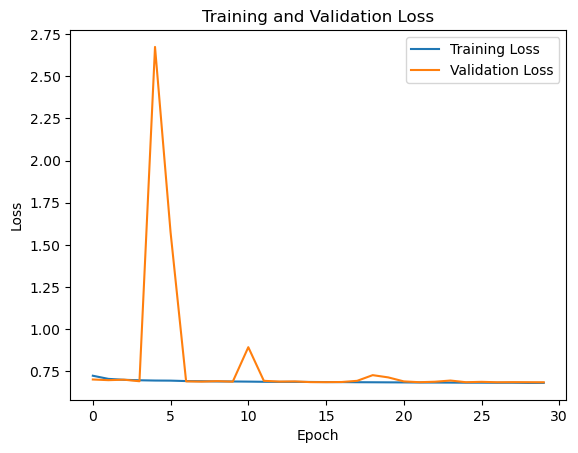

In [29]:
# Plot the training and validation losses
plt.plot(range(n_epochs), train_losses, label='Training Loss')
plt.plot(range(n_epochs), val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
# plt.xticks(range(n_epochs)+1)
# plt.xlim(0, n_epochs-1)
plt.legend()
plt.title("Training and Validation Loss")
plt.show()


### Evalution of model

[0.08331675 0.19119157 0.28913546 ... 0.05070351 0.5252618  0.13386181]


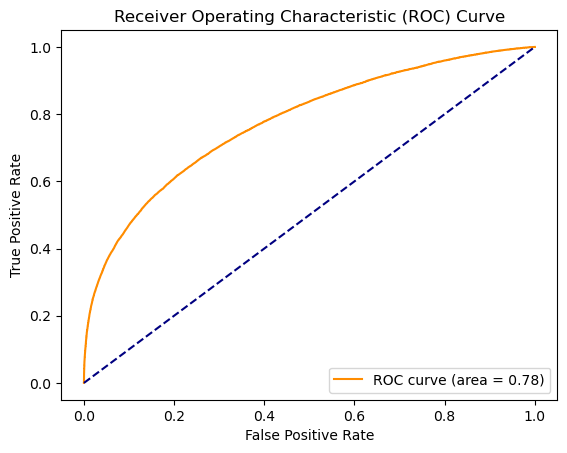

In [30]:
import torch
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Collect all predictions and true labels
all_outputs = []
all_labels = []

with torch.no_grad():
    for batch_x, batch_y, batch_wn, batch_wb in test_loader:
        # Get model outputs (logits if using BCEWithLogitsLoss)
        outputs = model(batch_x)
        
        # Apply sigmoid if necessary to get probabilities
        probs = torch.sigmoid(outputs).numpy()  # Convert to numpy for compatibility
        all_outputs.extend(probs)
        all_labels.extend(batch_y.numpy())

# Convert lists to numpy arrays
all_outputs = np.array(all_outputs).flatten()  # Flatten to a 1D array
print(all_outputs)
all_labels = np.array(all_labels)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_outputs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color="darkorange", label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")  # Diagonal line for random performance
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


### Histogram output plots

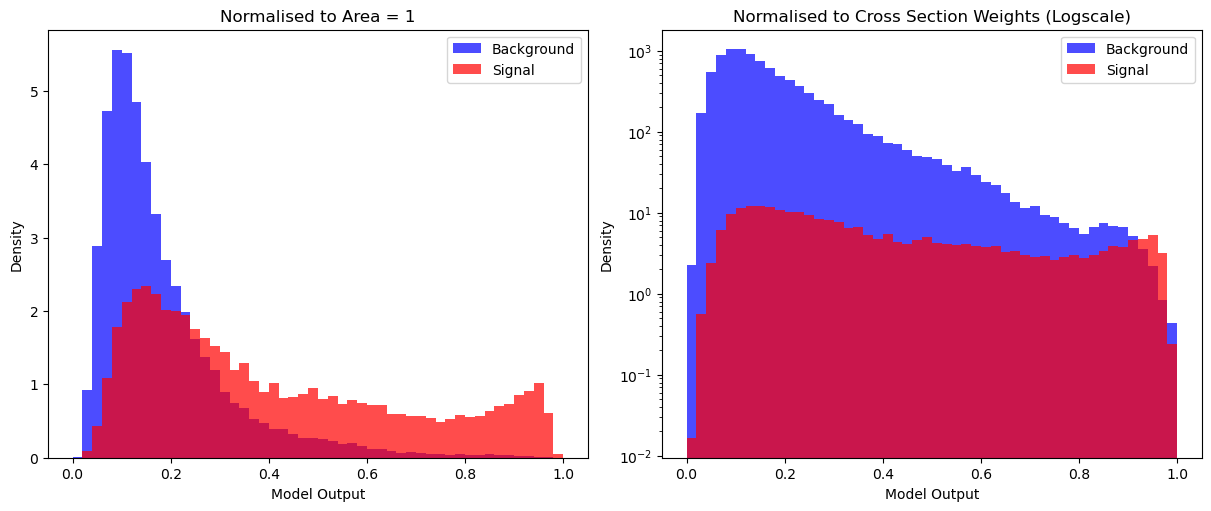

In [31]:
# Plot a hisogram of the model outputs for signal and background
model.eval()

# Collect all predictions and true labels

all_outputs = []
all_labels = []

with torch.no_grad():
    for batch_x, batch_y, batch_wn, batch_wb in test_loader:
        # Get model outputs (logits if using BCEWithLogitsLoss)
        outputs = model(batch_x)
        
        # Apply sigmoid if necessary to get probabilities
        probs = torch.sigmoid(outputs).numpy()  # Convert to numpy for compatibility
        all_outputs.extend(probs)
        all_labels.extend(batch_y.numpy())

# Convert lists to numpy arrays

all_outputs = np.array(all_outputs).flatten()  # Flatten to a 1D array
all_labels = np.array(all_labels)

# Plot the model outputs for signal and background

fig, axs = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# Plot 1: Normalized to Area = 1
axs[0].hist(all_outputs[all_labels == 0], bins=50, range=(0, 1), alpha=0.7, label='Background', density=True, color='b')
axs[0].hist(all_outputs[all_labels == 1], bins=50, range=(0, 1), alpha=0.7, label='Signal', density=True, color='r')
axs[0].set_xlabel('Model Output')
axs[0].set_ylabel('Density')
axs[0].set_title("Normalised to Area = 1")
# axs[1].set_xlim(0, 1
axs[0].legend()

# Plot 2: Normalized to Cross Section Weights (Logscaled)
axs[1].hist(all_outputs[all_labels == 0], bins=50, range=(0, 1), alpha=0.7, label='Background', weights=wn_test[all_labels == 0]*200000, color='b')
axs[1].hist(all_outputs[all_labels == 1], bins=50, range=(0, 1), alpha=0.7, label='Signal', weights=wn_test[all_labels == 1]*200000, color='r')
axs[1].set_xlabel('Model Output')
axs[1].set_ylabel('Density')
axs[1].set_title("Normalised to Cross Section Weights (Logscale)")
axs[1].set_yscale('log')
# axs[1].set_xlim(0, 1)
axs[1].legend()

plt.show()

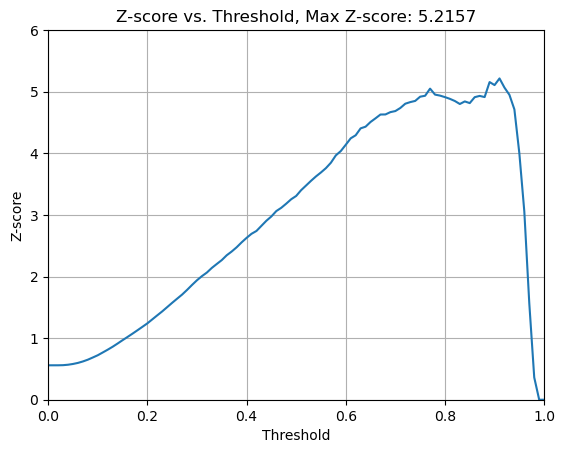

In [32]:
# Assume w_test is the array of weights for each sample in the test set
wn_test_array = np.array(wn_test*200000)

# Define thresholds between 0 and 1
thresholds = np.linspace(0, 1, 101)
z_scores = []

# Calculate the Z-score for each threshold using weights
for threshold in thresholds:
    # Weighted count of signal predictions above the threshold
    S = np.sum(wn_test_array[(all_outputs > threshold) & (all_labels == 1)])  # Weighted Signal
    B = np.sum(wn_test_array[(all_outputs > threshold) & (all_labels == 0)])  # Weighted Background
    sig_B = B * 0.05 # 5% error
    
    Z = S / np.sqrt(B + sig_B**2 + 1e-10)

    z_scores.append(Z)

# Plot Z-score vs. Threshold
plt.plot(thresholds, z_scores, label="Z-score")
plt.xlabel("Threshold")
plt.ylabel("Z-score")
plt.title(f"Z-score vs. Threshold, Max Z-score: {max(z_scores[:95]):.4f}")
plt.grid()
plt.ylim(0,6)
plt.xlim(0,1)
plt.show()

print()

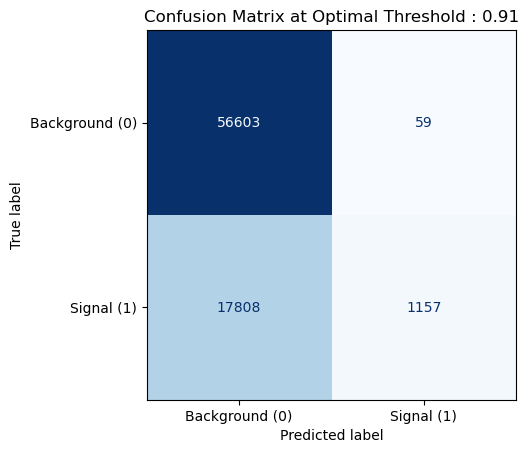

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define the optimal threshold
max_z_index = np.argmax(z_scores[:95])
optimal_threshold = max_z_index / 100

# Convert probabilities to binary predictions
predictions = (all_outputs > optimal_threshold).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(all_labels, predictions)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Background (0)", "Signal (1)"])
disp.plot(cmap="Blues", colorbar=False)
plt.title(f"Confusion Matrix at Optimal Threshold : {optimal_threshold}")
plt.show()

In [ ]:
# import shap
# Set the model to evaluation mode
model.eval()

# Collect all predictions and true labels
all_outputs = []
all_labels = []

with torch.no_grad():
    for batch_x, batch_y, batch_wn, batch_wb in test_loader:
        # Get model outputs (logits if using BCEWithLogitsLoss)
        outputs = model(batch_x)
        
        # Apply sigmoid if using BCEWithLogitsLoss to convert logits to probabilities
        probs = torch.sigmoid(outputs).cpu().numpy()  # Ensure on CPU before converting to numpy
        all_outputs.extend(probs.flatten())  # Flatten probabilities to 1D
        all_labels.extend(batch_y.cpu().numpy())  # Move labels to CPU and convert to numpy

# Convert lists to numpy arrays
all_outputs = np.array(all_outputs)
all_labels = np.array(all_labels)

# Create a wrapper function for the model to convert NumPy inputs to PyTorch tensors
def model_wrapper(x):
    # Convert NumPy array to PyTorch tensor
    tensor_x = torch.tensor(x, dtype=torch.float32)
    # Ensure tensor is on the same device as the model
    tensor_x = tensor_x.to(next(model.parameters()).device)
    # Return model output (logits)
    return model(tensor_x).detach().cpu().numpy()  # Convert back to NumPy

# Create a SHAP explainer
explainer = shap.Explainer(model_wrapper, test_loader.dataset.tensors[0].cpu().numpy())

# Calculate SHAP values
shap_values = explainer(test_loader.dataset.tensors[0].cpu().numpy())

PermutationExplainer explainer:  58%|█████▊    | 43591/75627 [25:49<18:08, 29.44it/s]

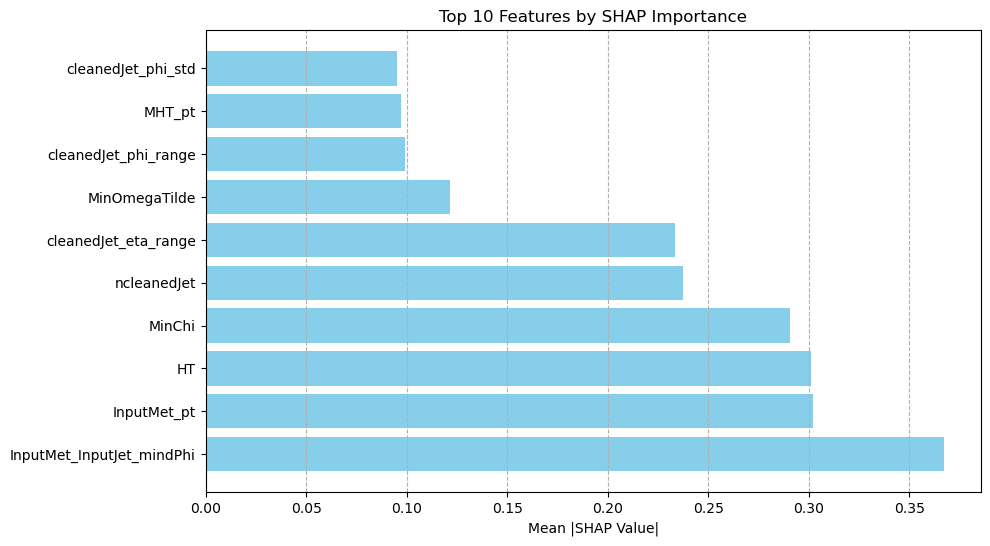

In [ ]:
# Get the mean absolute SHAP values for each feature
shap_mean_values = np.abs(shap_values.values).mean(axis=0)

# Get the indices of the top 10 features
top_10_indices = np.argsort(shap_mean_values)[-10:]

# Create a bar plot for the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(
    [features[i] for i in top_10_indices],  # Use feature names
    shap_mean_values[top_10_indices],      # Mean absolute SHAP values for top 10 features
    color="skyblue"
)
plt.xlabel("Mean |SHAP Value|")
plt.title("Top 10 Features by SHAP Importance")
plt.gca().invert_yaxis()  # Invert y-axis to display the highest importance at the top
plt.grid(axis="x", linestyle="--", alpha=1)
plt.show()
